In [12]:
import os, sys
sys.path.append('/home/ahnsunghyun/pytorch/ganomaly')
import cv2, torch
import matplotlib.pyplot as plt
from lib.networks import MyNetG
import numpy as np
import torchvision.transforms.functional as F

In [79]:
# 텐서를 이미지로 변환
def tensor_to_img(data,cv2=False):
    # get mean,std
    MEAN, STD = np.array([0.5, 0.5, 0.5]), np.array([0.5, 0.5, 0.5])

    # tensor to image
    img = data # Tensor Shape. [C, H, W]
    img = img.detach().cpu().numpy() # tensor -> numpy
    img = np.transpose(img, (1, 2, 0)) # [C,H,W] -> [H,W,C]
    img = np.clip(255.0 * (img * STD + MEAN), 0, 255) # denomalize
    img = img.astype(np.uint8).copy() # np.float32 -> np.uint8
    
    # image to cv2 image
    if cv2:
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR) # image is RGB, but cv2 is BGR

    return img

In [5]:
# imshow function (cv2 image -> plt image -> plt.show)
# cv2 image를 plt image로 출력 
def imshow(in_img):
    out_img = cv2.cvtColor(in_img,cv2.COLOR_BGR2RGB) 
    plt.figure(figsize=(5,5))
    plt.imshow(out_img)
    plt.axis('off')
    plt.show()

테스트 데이터 확인 (정상)

data/custom_helmet/test/0.normal/normal_tst_img_215.png


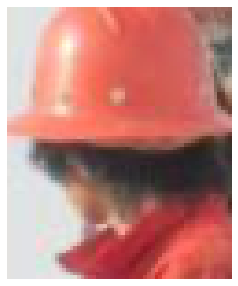

In [34]:
dir=os.path.join('data','custom_helmet','test','0.normal')
path=dir+'/'+'normal_tst_img_215.png'
print(path)
src1=cv2.imread(path,cv2.IMREAD_COLOR)
imshow(src1)

테스트 데이터 확인 (비정상)

data/custom_helmet/test/1.abnormal/abnormal_tst_img_632.png


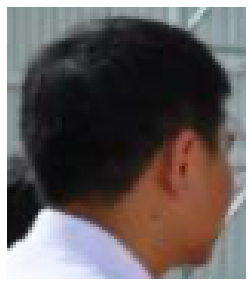

In [45]:
dir=os.path.join('data','custom_helmet','test','1.abnormal')
path=dir+'/'+'abnormal_tst_img_632.png'
print(path)
src2=cv2.imread(path,cv2.IMREAD_COLOR)
imshow(src2)

모델 불러오기

In [20]:
# check device
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# make model
netg = MyNetG().to(device)
# load weight
netg.load_state_dict(torch.load(os.path.join("output/ganomaly/custom_helmet/train/weights", 'netG.pth'))['state_dict'])

<All keys matched successfully>

이미지를 정규화된 텐서로 변환하는 함수

In [96]:
def cv2img_to_tensor(src):
    # resizing
    img=cv2.resize(src, (64, 64), interpolation=cv2.INTER_AREA)
    # cv2 to plt
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    # plt to tensor and normalization
    torch_img=F.to_tensor(img)
    torch_img=F.normalize(torch_img, mean=0.5, std=0.5)
    # edit shape|
    output=torch_img.view(1,3,64,64).to(device)

    return output

정규화된 텐서로 인퍼런스하는 함수

In [97]:
def inference(input):
    # inference
    fake, latent_i, latent_o = netg(input)
    
    return fake, latent_i, latent_o

이상치 점수 확인하는 함수

In [98]:
def get_anomaly_score(latent_i,latent_o):
    error = torch.mean(torch.pow((latent_i-latent_o), 2), dim=1)
    error_min, error_max = 0, 1
    anomaly_score=(error-error_min)/(error_max-error_min)
    return anomaly_score

이상치 점수 확인하기 (정상)

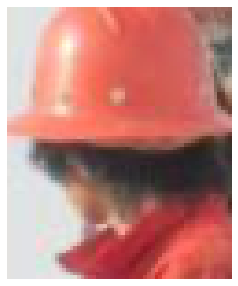

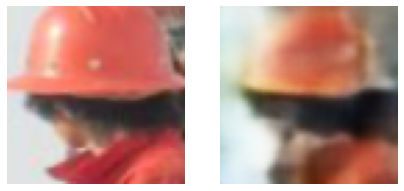

Anomaly Score: tensor([[[0.2380]]], device='cuda:0', grad_fn=<DivBackward0>)


In [99]:
# 정상 테스트 이미지 확인
imshow(src1)

# 점수 계산
real=cv2img_to_tensor(src1)
fake, latent_i, latent_o = inference(real)
anomaly_score=get_anomaly_score(latent_i,latent_o)

# 시각화 
f, a = plt.subplots(1,2,figsize=(7,7))
a=a.ravel()
for j,ax in enumerate(a):
    if j==0:
        real=tensor_to_img(real.view(3,64,64))
        ax.imshow(real)
    else:
        fake=tensor_to_img(fake.view(3,64,64))
        ax.imshow(fake)
    ax.axis('off')
plt.show()

# 출력 
print('Anomaly Score:',anomaly_score)

이상치 점수 확인하기 (비정상)

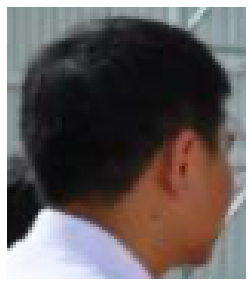

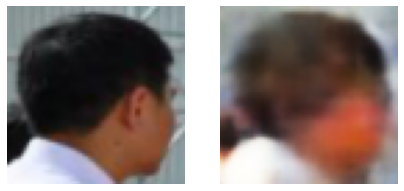

Anomaly Score: tensor([[[0.5079]]], device='cuda:0', grad_fn=<DivBackward0>)


In [100]:
# 비정상 테스트 이미지 확인
imshow(src2)

# 점수 계산
real=cv2img_to_tensor(src2)
fake, latent_i, latent_o = inference(real)
anomaly_score=get_anomaly_score(latent_i,latent_o)

# 시각화 
f, a = plt.subplots(1,2,figsize=(7,7))
a=a.ravel()
for j,ax in enumerate(a):
    if j==0:
        real=tensor_to_img(real.view(3,64,64))
        ax.imshow(real)
    else:
        fake=tensor_to_img(fake.view(3,64,64))
        ax.imshow(fake)
    ax.axis('off')
plt.show()

# 출력 
print('Anomaly Score:',anomaly_score)